# Matrix Factorization

# 1. Recommendations with User Ratings 

Build a matrix factorization model and tune it

For this part, we will:

* load and process the MovieLens 1M dataset, 
* build a matrix factorization model,
* tune three hyper-parameters of the matrix factorization model: training epoch, latent dimension and regularization weight,

In [1]:
import pandas as pd
import numpy as np
import copy 
from scipy.sparse import coo_matrix

data_df = pd.read_csv('./ratings.dat', sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()


## 1a: Build the Matrix Factorization Model 

First, let's implement the matrix factorization (MF for short) model. The MF model can be mathematically represented as: 

<center>
$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

To implement such an MF, here we will write a Python class for the model. There are three functions in this MF class: init, train, and predict. 

* The 'init' function is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation.

* The 'train' function is to train the MF model given the training data train_mat. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs having ratings in train_mat)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight.</center>
        
        3. After iterating over all user-movie pairs, we have finished the training for the current epoch. Now we will calculate and print out the value of the loss function L after this epoch, and the RMSE on test_mat by the current MF model. Then append them to lists to keep a record of them.


* The 'predict' function is to calculate the prediction_mat by the learned $\mathbf{P}$ and $\mathbf{Q}$.


In [2]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized
        
    def train(self, epoch=20, verbose=True):
        """
        Input: epoch -- the number of training epoch 
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        # adding this for later use
        # self.train_mat[self.train_mat==0] = np.nan
        
        epoch_loss_list = []
        epoch_test_RMSE_list = []
        
        valid_idx = np.nonzero(self.train_mat)
        valid_idx = np.asarray([list(i) for i in valid_idx]).T
        np.random.shuffle(valid_idx)
        
        for ep in range(epoch):
           
            np.random.shuffle(valid_idx)
            loss = 0
            
            for pair in valid_idx:
                
                user_id = pair[0]
                item_id = pair[1]
                
                inner_diff = np.dot(self.P[user_id], self.Q[item_id]) - self.train_mat[user_id][item_id]
                
                oldP = copy.deepcopy(self.P[user_id])
                oldQ = copy.deepcopy(self.Q[item_id])
                
                self.P[user_id] = oldP - self.lr*(np.dot(2*inner_diff, oldQ) + 2 * self.reg * oldP)
                self.Q[item_id] = oldQ - self.lr*(np.dot(2*inner_diff, oldP) + 2 * self.reg * oldQ)
                
                loss += inner_diff**2
                #print("init loss: ", loss)
            
            # get loss
            loss += np.sum(self.P**2) + np.sum(self.Q ** 2)
            epoch_loss_list.append(loss)
            
            prediction_mat = self.predict()
            
            # get rmse
            test_rmse = (np.sum(((prediction_mat - self.test_mat) * self.test_indicator_mat) ** 2) / np.sum(self.test_indicator_mat)) ** 0.5
            epoch_test_RMSE_list.append(test_rmse)
            
            print("epoch: ", ep+1, "loss: ", loss, "rmse: ", test_rmse)
            
        return epoch_loss_list, epoch_test_RMSE_list
        
        
    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

Now, let's train our MF model. Print out rmse and loss each epoch

In [3]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

epoch:  1 loss:  827657.4505993801 rmse:  0.9529133636994478
epoch:  2 loss:  653392.558701163 rmse:  0.9463216877090511
epoch:  3 loss:  641565.4774190057 rmse:  0.9403141912444866
epoch:  4 loss:  625651.7474259987 rmse:  0.9301072916708012
epoch:  5 loss:  609755.3033218854 rmse:  0.9225286390437941
epoch:  6 loss:  598917.9530675136 rmse:  0.9167700224453103
epoch:  7 loss:  590255.7915579269 rmse:  0.9143076669943043
epoch:  8 loss:  583716.406166773 rmse:  0.9136973260619572
epoch:  9 loss:  578566.0230914538 rmse:  0.9105881748634426
epoch:  10 loss:  574323.2138144231 rmse:  0.906812057357852
epoch:  11 loss:  570341.1794378753 rmse:  0.9070699258941938
epoch:  12 loss:  567290.0960528682 rmse:  0.9033078056091737
epoch:  13 loss:  565035.6256033351 rmse:  0.9032570317958981
epoch:  14 loss:  562641.2586991414 rmse:  0.9036859432538512
epoch:  15 loss:  560511.2918342097 rmse:  0.9019807600859546
epoch:  16 loss:  559095.1154194984 rmse:  0.9012418614588453
epoch:  17 loss:  55

In [4]:
print(epoch_loss_list)
print(epoch_test_RMSE_list)

[827657.4505993801, 653392.558701163, 641565.4774190057, 625651.7474259987, 609755.3033218854, 598917.9530675136, 590255.7915579269, 583716.406166773, 578566.0230914538, 574323.2138144231, 570341.1794378753, 567290.0960528682, 565035.6256033351, 562641.2586991414, 560511.2918342097, 559095.1154194984, 558133.519676567, 556923.0236040135, 555740.5698659815, 554987.0061307057]
[0.9529133636994478, 0.9463216877090511, 0.9403141912444866, 0.9301072916708012, 0.9225286390437941, 0.9167700224453103, 0.9143076669943043, 0.9136973260619572, 0.9105881748634426, 0.906812057357852, 0.9070699258941938, 0.9033078056091737, 0.9032570317958981, 0.9036859432538512, 0.9019807600859546, 0.9012418614588453, 0.901211110151327, 0.9020991122283145, 0.9001056434668978, 0.8999473534449612]


## Part 1b: Tune Hyper-parameters in Matrix Factorization 
In Part 1a, we trained an MF model with latent dimension set as 5, regularization weight as 0.001, training epoch as 20. However, it is not clear whether these are good choices or not. Hence, in this part, we will tune these hyper-parameters to train an effective model.

A most straightforward but powerful method is to grid search each hyper-parameter and find the best one based on the RMSE on test_mat. In this part, we will do the grid search for train epoch, latent dimension, and regularization weight.

#### Tune training epoch####

For training epoch, we only need to run the experiment of MF for one time, and record the test RMSE for each epoch and find the epoch that produces the best test RMSE. To visually show the change of test RMSE corresponding to the training epoch, we can plot the test RMSE for each epoch in a figure as shown in the next cell.

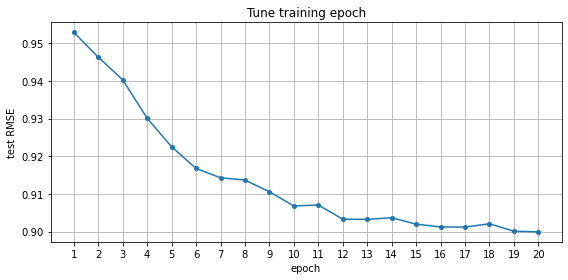

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, our best epoch appears to be 20

#### Tune latent dimension####

By this figure, you can find the best epoch for your MF model. Similarly, you can plot how the test RMSE changes when you set different latent dimensions. For this, we will run the MF model with 'latent' as {1,3,5,7,9}, and plot the corresponding test RMSE for these five different latent dimensions in the next cell. 

Keep in mind, we want to use the earlier epoch of 20.

In [7]:
lat_rmse = []

for lat in [1,3,5,7,9]:
    
    print("lat # ", lat)
    
    mf_lat = MF(train_mat, test_mat, latent=lat, lr=0.01, reg=0.001)
    lat_loss_list, lat_test_RMSE_list = mf_lat.train(epoch=20)
    
    print("min rmse idx: ", lat_test_RMSE_list.index(lat_test_RMSE_list[-1]))
    lat_rmse.append(min(lat_test_RMSE_list))


lat #  1
epoch:  1 loss:  1217868.998798008 rmse:  0.9632415893480263
epoch:  2 loss:  661605.4495584227 rmse:  0.9504914316539963
epoch:  3 loss:  653871.5862616678 rmse:  0.9482938826813115
epoch:  4 loss:  651568.0570189967 rmse:  0.9443092451167232
epoch:  5 loss:  651195.1219903945 rmse:  0.9463281397985686
epoch:  6 loss:  650566.3098423337 rmse:  0.9456467953171245
epoch:  7 loss:  650388.9327826481 rmse:  0.9442596977018384
epoch:  8 loss:  649605.0756565956 rmse:  0.9441751440752482
epoch:  9 loss:  650007.5557014819 rmse:  0.9449176470659353
epoch:  10 loss:  649776.0424792895 rmse:  0.9440828987839115
epoch:  11 loss:  649839.4717772579 rmse:  0.944227874291325
epoch:  12 loss:  649692.1761144999 rmse:  0.9446787592512345
epoch:  13 loss:  649352.7484941497 rmse:  0.9429920932160186
epoch:  14 loss:  649194.194730483 rmse:  0.9440781554334311
epoch:  15 loss:  649430.9200945429 rmse:  0.9436064063555725
epoch:  16 loss:  649672.4169421145 rmse:  0.9434914828372405
epoch:  17

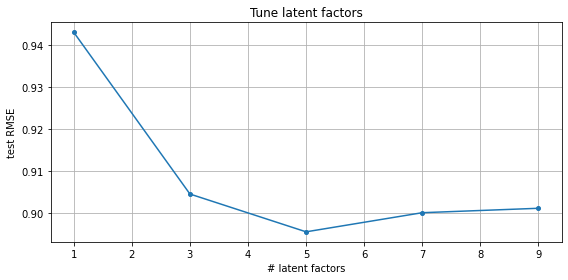

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot([1,3,5,7,9], lat_rmse, marker='.', linewidth=1.5, markersize=8)
ax.set_ylabel('test RMSE')
ax.set_xlabel('# latent factors')
ax.set_title('Tune latent factors')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, the best latent dimension for your MF model appears to be 5.

#### Tune regularization weight####

Last, we can plot how the test RMSE changes when we set different regularization weight. Now we'll run the MF model with 'reg' as {0.0001,0.0005,0.001,0.0015,0.002}, and plot corresponding test RMSE for these five different regularization weights in the next cell. 

In [10]:
reg_rmse = []

for reg_weight in [0.0001,0.0005,0.001,0.0015,0.002]:
    
    print("reg # ", reg_weight)
    
    mf_reg = MF(train_mat, test_mat, latent=5, lr=0.01, reg=reg_weight)
    reg_loss_list, reg_test_RMSE_list = mf_reg.train(epoch=20)
    
    reg_rmse.append(reg_test_RMSE_list[-1])

reg #  0.0001
epoch:  1 loss:  825110.2957107738 rmse:  0.9530497751528018
epoch:  2 loss:  653052.2676773634 rmse:  0.9462171950775167
epoch:  3 loss:  639041.0447429839 rmse:  0.9369209353417328
epoch:  4 loss:  620346.5953087684 rmse:  0.9259357567484029
epoch:  5 loss:  604715.9193908174 rmse:  0.9179425506132218
epoch:  6 loss:  592543.1291386582 rmse:  0.9145503614433629
epoch:  7 loss:  583148.2955204552 rmse:  0.9088616459471442
epoch:  8 loss:  575950.9444161239 rmse:  0.9057703981897681
epoch:  9 loss:  570621.431626666 rmse:  0.9047110640126482
epoch:  10 loss:  566533.7845545493 rmse:  0.9027797177913139
epoch:  11 loss:  563682.1321365032 rmse:  0.900749638062956
epoch:  12 loss:  560989.4196674775 rmse:  0.8993200259042038
epoch:  13 loss:  558307.7044178143 rmse:  0.8991726563721157
epoch:  14 loss:  556642.0318852621 rmse:  0.8994177374139488
epoch:  15 loss:  555737.6627921547 rmse:  0.8981552396411622
epoch:  16 loss:  554342.2486712866 rmse:  0.8978501762437849
epoch

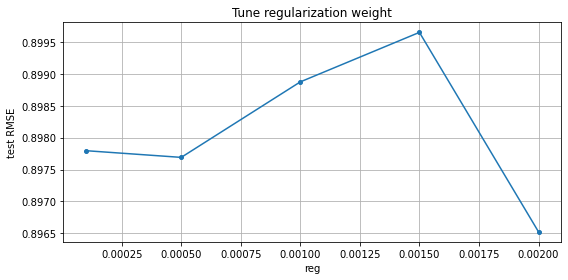

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot([0.0001,0.0005,0.001,0.0015,0.002], reg_rmse, marker='.', linewidth=1.5, markersize=8)
ax.set_ylabel('test RMSE')
ax.set_xlabel('reg')
ax.set_title('Tune regularization weight')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, the best regularization weight for your MF model appears to be 0.002

# Part 2. Recommendations with implicit feedback 

Now we turn implement matrix factorization for recommendations with implicit feedback

Before the algorithm implementation, we need to first transfer the explicit datasets to implicit ones.

In [ ]:
train_mat = (train_mat > 0).astype(float)
test_mat = (test_mat > 0).astype(float)

Now we implement our MF algorithm

The only challenge now is that in an implicit feedback dataset, there is only positive signal (i.e., '1' in the train_mat) without negative signal. Hence, to let our MF work for this implicit feedback, a simple but powerful method -- random negative sampling -- can be adopted. The main idea is that in each training epoch, we randomly sample user-movie pairs without positive feedback in train_mat (user-movie pairs with '0' in train_mat) to be negative feedback, and mix them with positive feedback as the training data to train the MF model.

In the Next cell, we write the MF_implicit class. There are five functions in this class: 

* 'init' is to initialize variables; 

* 'negative_sampling' is to do the random negative sampling to generate negative signals for training the MF. It returns a list of users and a list of movies as the training samples, mixing positive and negative user-movie pairs.

* 'test is to evaluate the trained MF on test_mat and print out recall@k and precision@k. 

* 'predict' is to generate the ranked lists of movies by the trained MF for every user, we store the ranking result (named 'recommendation') in a numpy array of size (#user, 50), where entry (u, k) represents the movie id that is ranked at position k in the recommendation list to user u. 

* 'train' is to train the MF model. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main logic of this function is the same as the one in Part 1a.

        1. Call 'negative_sampling()' to generate a list of users and a list of movies mixing positive and negative user-movie pairs as training samples.
        2. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs from step 1)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight, and $r_{u,i}$ now takes binary value.</center>
        
        3. After iterating over all user-movie pairs, we call 'test()' to evaluate the current MF model.

In [57]:
class MF_implicit:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)
        
        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function
        
        self.num_user, self.num_movie = train_mat.shape
        
        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.user_test_like = []
        for u in range(self.num_user):
            self.user_test_like.append(np.where(self.test_mat[u, :] > 0)[0])

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized
        
    def negative_sampling(self):
        negative_movie = np.random.choice(np.arange(self.num_movie), size=(len(self.sample_user)), replace=True)
        true_negative = self.train_mat[self.sample_user, negative_movie] == 0
        negative_user = self.sample_user[true_negative]
        negative_movie = negative_movie[true_negative]
        return np.concatenate([self.sample_user, negative_user]), np.concatenate([self.sample_movie, negative_movie])

    def train(self, epoch=20):
        """
        Input: epoch -- the number of training epoch 
        """
        
        for ep in range(epoch):
            """ 
           Implement the training process for one epoch, 
            """
            print('START EPOCH ', ep+1)
            
            valid_user, valid_movie = self.negative_sampling()
            valid_idx = np.asarray([list(pair) for pair in zip(valid_user, valid_movie)])
            np.random.shuffle(valid_idx)
            
            for pair in valid_idx:
                
                
                user_id = pair[0]
                item_id = pair[1]
                                
                inner_diff = np.dot(self.P[user_id], self.Q[item_id]) - self.train_mat[user_id][item_id]
                               
                oldP = copy.deepcopy(self.P[user_id])
                oldQ = copy.deepcopy(self.Q[item_id])
                                
                self.P[user_id] = oldP - self.lr*(np.dot(2*inner_diff, oldQ) + 2 * self.reg * oldP)
                self.Q[item_id] = oldQ - self.lr*(np.dot(2*inner_diff, oldP) + 2 * self.reg * oldQ)
                
            print('END EPOCH ', ep+1)
            
            self.test()

            
    def predict(self):
        """
        create ranked list for prediction function
        """
        recommendation = np.empty([self.num_user, 50])
        prediction_mat = np.matmul(self.P, self.Q.T)

        for user_id in range(self.num_user):
            
            # get indices of all unwatched movies
            recommendation[user_id] = np.argpartition(prediction_mat[user_id], -50)[-50:]
                
        return recommendation
    
    def test(self):
        recommendation = self.predict()

        recalls = np.zeros(3)
        precisions = np.zeros(3)
        user_count = 0.

        for u in range(self.num_user):
            test_like = self.user_test_like[u]
            test_like_num = len(test_like)
            if test_like_num == 0:
                continue
            rec = recommendation[u, :]
            hits = np.zeros(3)
            for k in range(50):
                if rec[k] in test_like:
                    if k < 50:
                        hits[2] += 1
                        if k < 20:
                            hits[1] += 1
                            if k < 5:
                                hits[0] += 1
            recalls[0] += (hits[0] / test_like_num)
            recalls[1] += (hits[1] / test_like_num)
            recalls[2] += (hits[2] / test_like_num)
            precisions[0] += (hits[0] / 5.)
            precisions[1] += (hits[1] / 20.)
            precisions[2] += (hits[2] / 50.)
            user_count += 1

        recalls /= user_count
        precisions /= user_count

        print('recall@5\t[%.6f],\t||\t recall@20\t[%.6f],\t||\t recall@50\t[%.6f]' % (recalls[0], recalls[1], recalls[2]))
        print('precision@5\t[%.6f],\t||\t precision@20\t[%.6f],\t||\t precision@50\t[%.6f]' % (precisions[0], precisions[1], precisions[2]))
        print('')

In [50]:
test = np.asarray([1,0,0,0,0,1,1,0])

test_unwatch = np.argwhere(test==1)
for i in test_unwatch:
    v = test[i]
    print(v, type(v))

#np.array([prediction_mat[user_id][item] for item in user_unwatched])

[1] <class 'numpy.ndarray'>
[1] <class 'numpy.ndarray'>
[1] <class 'numpy.ndarray'>


In [58]:
mf_implicit = MF_implicit(train_mat, test_mat, latent=5, lr=0.01, reg=0.0001)
mf_implicit.train(epoch=20)

start epoch  1
end epoch  1
recall@5	[0.010331],	||	 recall@20	[0.049644],	||	 recall@50	[0.141956]
precision@5	[0.081225],	||	 precision@20	[0.092417],	||	 precision@50	[0.100305]

start epoch  2
end epoch  2
recall@5	[0.012149],	||	 recall@20	[0.053197],	||	 recall@50	[0.152901]
precision@5	[0.094139],	||	 precision@20	[0.100637],	||	 precision@50	[0.109132]

start epoch  3
end epoch  3
recall@5	[0.012874],	||	 recall@20	[0.057717],	||	 recall@50	[0.166676]
precision@5	[0.097417],	||	 precision@20	[0.105240],	||	 precision@50	[0.116212]

start epoch  4
end epoch  4
recall@5	[0.013400],	||	 recall@20	[0.059696],	||	 recall@50	[0.173194]
precision@5	[0.104669],	||	 precision@20	[0.108825],	||	 precision@50	[0.119315]

start epoch  5
end epoch  5
recall@5	[0.014123],	||	 recall@20	[0.062208],	||	 recall@50	[0.177607]
precision@5	[0.103841],	||	 precision@20	[0.109975],	||	 precision@50	[0.120222]

start epoch  6
end epoch  6
recall@5	[0.014187],	||	 recall@20	[0.062388],	||	 recall@50	[